In [ ]:
import spacy
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
from itertools import chain
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = 'serif'
import time

import seaborn as sns
sns.set_theme(palette="pastel", style="white")

In [ ]:
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_trf

2023-08-16 02:14:36.658489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
%pip install pyarrow

import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
# ner = spacy.load("en_core_web_sm")
# ner = spacy.load("en_core_web_md")
ner = spacy.load("en_core_web_lg")
# ner = spacy.load("en_core_web_trf")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_2020_transformer = pd.read_csv('/content/gdrive/MyDrive/Colab dataset/df_2020_transformer.csv')
df_2021_transformer = pd.read_csv('/content/gdrive/MyDrive/Colab dataset/df_2021_transformer.csv')
df_2022_transformer = pd.read_csv('/content/gdrive/MyDrive/Colab dataset/df_2022_transformer.csv')
df_2023_transformer = pd.read_csv('/content/gdrive/MyDrive/Colab dataset/df_2023_transformer.csv')

dataframes = [df_2020_transformer, df_2021_transformer, df_2022_transformer, df_2023_transformer]
df_relevant_articles = pd.concat(dataframes, ignore_index=True)

In [ ]:
sample_df = df_relevant_articles.sample(frac=0.7, replace=False, random_state=1)

sample_df.head()

,date,processed_text,sentiment_prob_trans,sentiment_label_trans
129453,2023-01-28,remark stock jump 16 ai partnership taiwan aae...,[[2.8654735e-04 6.7784946e-04 9.9903560e-01]],2
120075,2023-03-03,best mwc screen roll chatgpt interactive glass...,[[1.0264391e-04 9.9967241e-01 2.2500243e-04]],1
87046,2022-09-12,argo ai introduces complete line autonomous ve...,[[9.8714256e-05 9.9427032e-01 5.6309723e-03]],1
26686,2021-02-05,two google employee quit ai researcher timnit ...,[[7.4289301e-03 9.9237871e-01 1.9239467e-04]],1
49249,2021-04-22,sony patent ai bot play game pc gamer sony pat...,[[7.6042255e-05 9.9969685e-01 2.2716426e-04]],1


In [ ]:
sample_df.head()

,date,processed_text,sentiment_prob_trans,sentiment_label_trans,people,organizations,products,top_peo,top_org,top_prod,month
129453,2023-01-28,remark stock jump 16 ai partnership taiwan aae...,[[2.8654735e-04 6.7784946e-04 9.9903560e-01]],2,"[AAEON MARKETWATCH, REX NUTTING U ECONOMIC, SE...","[DOW JONES NEWSWIRES REMARK, OJEA REMARK HOLDI...",[],[],"[ETF, IRS]",[],2023-01
120075,2023-03-03,best mwc screen roll chatgpt interactive glass...,[[1.0264391e-04 9.9967241e-01 2.2500243e-04]],1,"[CASSANDRA ALLWOOD JAMES BROOK, GERRIT SCHNEEM...","[GFK, SURREY NOWLEADER BLACK PRESS GROUP LTD, ...",[],"[KELVIN CHAN, TECNO]","[XRAY, CONGRESS, CHATGPT, LENOVO, BC LIBERAL, ...",[],2023-03
87046,2022-09-12,argo ai introduces complete line autonomous ve...,[[9.8714256e-05 9.9427032e-01 5.6309723e-03]],1,"[BRETT, BUSINESSU, NEWSPROUD FARMERSEND, LEGAC...","[WEEK2022, USHEROES AMONG U, MUSIC LIFESTYLEGR...",[PICKEM 10],"[NEWSPROUD FARMERSEND, LEGACYCRIMEEDUCATIONEDI...","[USHEROES AMONG U, GRAY MEDIUM GROUP INC, AREA...",[],2022-09
26686,2021-02-05,two google employee quit ai researcher timnit ...,[[7.4289301e-03 9.9237871e-01 1.9239467e-04]],1,"[FIA GM, MAC MANCHESTER, TIMNIT GEBRU, AUDI BE...","[GOOGLE, DELL DNA DODGE, XBOX, CONGRESS, ACER,...",[],[TIMNIT GEBRU],"[GOOGLE, XBOX, CONGRESS, ACER, YAHOO, EBAY, FBI]",[],2021-02
49249,2021-04-22,sony patent ai bot play game pc gamer sony pat...,[[7.6042255e-05 9.9969685e-01 2.2716426e-04]],1,"[VALHEIM RAINBOW, CHINO SONY, ALAN DEXTER ALAN...","[SEGMENTNEXT US, U INC INTERNATIONAL MEDIUM GR...",[],[],"[U INC INTERNATIONAL MEDIUM GROUP, SONY]",[],2021-04


In [ ]:
def extract_entities(text):
    doc = ner(text, disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
    people = set()
    organizations = set()
    products = set()
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            people.add(ent.text.upper())
        elif ent.label_ == 'ORG':
            organizations.add(ent.text.upper())
        elif ent.label_ == 'PRODUCT':
            products.add(ent.text.upper())
    return list(people), list(organizations), list(products)


In [ ]:
%%time
#sample_df = sample_df.head(100)
sample_df[['people', 'organizations', 'products']] = sample_df['processed_text'].apply(extract_entities).apply(pd.Series)

CPU times: user 1h 3min 6s, sys: 20.2 s, total: 1h 3min 27s
Wall time: 1h 3min 19s


In [ ]:
sample_df

,date,processed_text,sentiment_prob_trans,sentiment_label_trans,people,organizations,products,top_peo,top_org,top_prod,month
129453,2023-01-28,remark stock jump 16 ai partnership taiwan aae...,[[2.8654735e-04 6.7784946e-04 9.9903560e-01]],2,"[AAEON MARKETWATCH, REX NUTTING U ECONOMIC, SE...","[DOW JONES NEWSWIRES REMARK, OJEA REMARK HOLDI...",[],[],"[ETF, IRS]",[],2023-01
120075,2023-03-03,best mwc screen roll chatgpt interactive glass...,[[1.0264391e-04 9.9967241e-01 2.2500243e-04]],1,"[CASSANDRA ALLWOOD JAMES BROOK, GERRIT SCHNEEM...","[GFK, SURREY NOWLEADER BLACK PRESS GROUP LTD, ...",[],"[KELVIN CHAN, TECNO]","[XRAY, CONGRESS, CHATGPT, LENOVO, BC LIBERAL, ...",[],2023-03
87046,2022-09-12,argo ai introduces complete line autonomous ve...,[[9.8714256e-05 9.9427032e-01 5.6309723e-03]],1,"[BRETT, BUSINESSU, NEWSPROUD FARMERSEND, LEGAC...","[WEEK2022, USHEROES AMONG U, MUSIC LIFESTYLEGR...",[PICKEM 10],"[NEWSPROUD FARMERSEND, LEGACYCRIMEEDUCATIONEDI...","[USHEROES AMONG U, GRAY MEDIUM GROUP INC, AREA...",[],2022-09
26686,2021-02-05,two google employee quit ai researcher timnit ...,[[7.4289301e-03 9.9237871e-01 1.9239467e-04]],1,"[FIA GM, MAC MANCHESTER, TIMNIT GEBRU, AUDI BE...","[GOOGLE, DELL DNA DODGE, XBOX, CONGRESS, ACER,...",[],[TIMNIT GEBRU],"[GOOGLE, XBOX, CONGRESS, ACER, YAHOO, EBAY, FBI]",[],2021-02
49249,2021-04-22,sony patent ai bot play game pc gamer sony pat...,[[7.6042255e-05 9.9969685e-01 2.2716426e-04]],1,"[VALHEIM RAINBOW, CHINO SONY, ALAN DEXTER ALAN...","[SEGMENTNEXT US, U INC INTERNATIONAL MEDIUM GR...",[],[],"[U INC INTERNATIONAL MEDIUM GROUP, SONY]",[],2021-04
...,...,...,...,...,...,...,...,...,...,...,...
100321,2023-07-13,lark health ai coaching drive weight loss resu...,[[5.3411431e-04 5.8832622e-01 4.1113967e-01]],1,"[LOWESTCOST DPP, AGOMOUNTAIN, HPSA, INTERVIEWS...","[DIGITAL WELLNESS PROGRAM, HPSA RURALURBAN, 20...",[],"[AGOMOUNTAIN, INTERVIEWSPAY FORWARDNEW, SCHEDU...","[INTELLIGENCEA GRAY MEDIUM GROUP INC, APPSGO L...",[],2023-07
20741,2020-03-20,artificial intelligence platform market data a...,[[1.627425e-04 9.905460e-01 9.291302e-03]],1,"[ALBERT, R WORDPRESSORG, BRIGHTERION KITTAI IF...","[COMMENTSKELAPEK CARDIOLOGY, POSTNEXT, ETHICON...",[],"[ALBERT, R WORDPRESSORG, BRIGHTERION KITTAI IF...","[POSTNEXT, BAIDU IBM, INTEL]",[],2020-03
50127,2021-02-20,weekly wrap bank face daunting cybersecurity r...,[[3.0926112e-04 9.9941552e-01 2.7527168e-04]],1,[TAG PREMIUMRISK],"[IBM, WATSON HEALTH, WSJ, WEEKLY WRAP BANK, MA...",[],[],"[IBM, WSJ, ADA]",[],2021-02
71168,2022-01-16,raymond james associate 177 million stake firs...,[[6.1245094e-04 2.9510623e-01 7.0428139e-01]],2,"[JANNEY MONTGOMERY SCOTT LLC, CYNTHIA VAUGHN, ...","[PIPER SANDLER DELTA AIR LINE, STOCKTWITS RAYM...",[LONFXPO],[],"[JPMORGAN CHASE CO, CFINANCIALNEWS, ETF, SEC, ...",[],2022-01


In [ ]:
# Flatten the lists in 'people', 'organizations', and 'products' columns
people_flat = [person for sublist in sample_df['people'] for person in sublist]
organization_flat = [org for sublist in sample_df['organizations'] for org in sublist]
product_flat = [prod for sublist in sample_df['products'] for prod in sublist]

# Count the occurrences of people, organizations, and products
people_counts = pd.Series(people_flat).value_counts()
organization_counts = pd.Series(organization_flat).value_counts()
product_counts = pd.Series(product_flat).value_counts()

# Create DataFrames to store the counts
people_df = pd.DataFrame({'person': people_counts.index, 'count': people_counts.values})
organization_df = pd.DataFrame({'organization': organization_counts.index, 'count': organization_counts.values})
product_df = pd.DataFrame({'product': product_counts.index, 'count': product_counts.values})

In [ ]:
not_peo = ['CAPTIONINGAUDIO DESCRIPTIONA GRAY MEDIUM GROUP INC', 'GRETA VAN SUSTERENCIRCLE - COUNTRY','YOU.S.',
           'PORTER','BING','SIZE','DANMARK DEUTSCHLAND ESPA', 'GRETA VAN SUSTERENCIRCLE COUNTRY',
           'INSTAGRAM','SU TIERRA TIEMPO','COSTELLO','PM EDT|UPDATED','YOU.S.A. PHONE NO','BARD','JUN',
           'GRETA VAN SUSTERENGRAY DC', 'MD', 'WIE BEWERTEN SIE','BEWERTEN','KOSTENLOSE VON UND FNRD-',
           'NEWSUP', 'FORBES', 'RISIKEN', 'DEEP', 'WIR EMPFEHLEN INTERESSENTEN UND POTENZIELLEN ANLEGERN DEN BASISPROSPEKT',
           'WERTPAPIERE ZU VERSTEHEN', 'BEVOR SIE EINE TREFFEN', 'VERSTEHEN SEIN KANN', 'MAX', 'GB',
           'TVLATEST NEWSCASTSPRESS', 'HEREMORE', 'PRODUCT HUNT', 'R GDPR', 'NORGE POLSKA', 'BUREAUINVESTIGATE', 'INFOHELP',
           'MONACO MONGOLIA', 'VERDE CAYMAN', 'COMOROS CONGOBRAZZAVILLE CONGOKINSHASA',
           'GREECE GUAM GUATEMALA', 'JORDAN KANSA', 'TURKEY TURKMENISTAN', 'U NEPAL', 'U PERU', 'BAIDU']
not_org = ['AI','ARTIFICIAL INTELLIGENCE','GLOBALLY ARTIFICIAL INTELLIGENCE','GRAY MEDIA GROUP',
           'MACHINE LEARNING','ML','BARD','COMPANY', 'STATE', 'SERVICEPRIVACY POLICYEEO GRAY MEDIA GROUP',
           'FACEBOOK SHARE','REUTERS','WORDPRESS | THEME','SERVICEPRIVACY POLICYEEO STATEMENTFCC GRAY MEDIA GROUP',
           'LLC','SERVICEPRIVACY POLICYEEO DESCRIPTIONA GRAY MEDIA GROUP','POLLS AND','THE ASSOCIATED PRESS',
           'GLOBAL ARTIFICIAL INTELLIGENCE','THE ARTIFICIAL INTELLIGENCE','THE ASSOCIATED PRESS',
           'ASSOCIATED PRESS','AP', '20022022 GRAY TELEVISION INC', '20022023 GRAY TELEVISION INC', 'FCC', 'MUSIC LIFESTYLEGRAY DC', 'UNITED STATE']

# Filtering the DataFrame
people_df = people_df[~people_df.isin(not_peo)].dropna(how='any')
organization_df = organization_df[~organization_df.isin(not_org)].dropna(how='any')

In [ ]:
people_df['person']

0                                             SAM ALTMAN
1                                                  BIDEN
2                                              JOE BIDEN
3                                           DONALD TRUMP
4                                               KUTZTOWN
                             ...                        
146    SCHOOLSEE CERTIFICATESCOURSERAABOUTWHAT OFFERL...
147                   SKILLSBLOCKCHAINSEE COURSESPOPULAR
148                          SKILLSSKILLS FINANCEPOPULAR
149                                               TAKEIS
150    TRANSACTIONSNEW CONTRACTSPROFIT WARNINGSAPPOIN...
Name: person, Length: 151, dtype: object

In [ ]:
# Filter the DataFrame based on the 25th percentile
people_df = people_df[people_df['count'] > np.percentile(people_df['count'], 25)]
organization_df = organization_df[organization_df['count'] > np.percentile(organization_df['count'], 25)]
product_df = product_df[product_df['count'] > np.percentile(product_df['count'], 25)]

# Ignore entries with counts less than 100 times
entity_threshold = 100
people_df = people_df[people_df['count'] >= entity_threshold]
organization_df = organization_df[organization_df['count'] >= entity_threshold]
product_df = product_df[product_df['count'] >= entity_threshold]

In [ ]:
# Sort the counts DataFrame in descending order based on count values
people_df = people_df.sort_values(by=['count','person'], ascending=[False,True], ignore_index=True)
organization_df = organization_df.sort_values(by=['count','organization'], ascending=[False,True], ignore_index=True)
product_df = product_df.sort_values(by=['count','product'], ascending=[False,True], ignore_index=True)

# Convert the relevant counts DataFrame columns to sets
most_mentioned_people = set(people_df['person'])
most_mentioned_organizations = set(organization_df['organization'])
most_mentioned_products = set(product_df['product'])

In [ ]:
people_df.head(10)

,person,count
0,SAM ALTMAN,2139
1,BIDEN,1866
2,JOE BIDEN,1572
3,DONALD TRUMP,1412
4,KUTZTOWN,982
5,WFMZTV WFMZTV,981
6,SUNDAR PICHAI,943
7,ADVICEFAMILY RELATIONSHIPSPROTESTSFESTIVALHOME...,922
8,DRINKSPETSBEAUTY FASHIONANIMALSSHOPPINGHOME,922
9,SAFETYNUTRITIONSPORTSSPORTSFOOTBALLNFLSOCCERBA...,922


In [ ]:
organization_df.head(10)

,organization,count
0,CHATGPT,13573
1,IBM,8770
2,MICROSOFT,8238
3,ANDROID,6155
4,GOOGLE,5498
5,FDA,4865
6,DATADRIVEN,4033
7,CONGRESS,3660
8,U STATE,3330
9,SAMSUNG,2968


In [ ]:
product_df.head(10)

,product,count
0,GOOGLE,9549
1,AIDRIVEN,3859
2,VOIP,3022
3,VKONTAKTE,1612
4,ACCUWEATHER,981
5,SAAS,776
6,NVIDIA,668
7,GMT,621
8,ML,585


In [ ]:
# Clean the 'people' column to include only the most mentioned people
sample_df['top_peo'] = sample_df['people'].apply(lambda x: [person for person in x if person in most_mentioned_people])

# Clean the 'organizations' column to include only the most mentioned organizations
sample_df['top_org'] = sample_df['organizations'].apply(lambda x: [org for org in x if org in most_mentioned_organizations])

# Clean the 'products' column to include only the most mentioned products
sample_df['top_prod'] = sample_df['products'].apply(lambda x: [prod for prod in x if prod in most_mentioned_products])

### AI solutions

In [ ]:
# Define a mapping for replacement
replacement_mapping = {1: "positive", 2: "negative"}

# Replace values in the 'sentiment_label_trans' column using the mapping
sample_df['sentiment_label_trans'] = sample_df['sentiment_label_trans'].replace(replacement_mapping)


In [ ]:
# Define a mapping dictionary for abbreviations to full names
abbreviation_mapping = {
    'ARTIFICIAL INTELLIGENCE': 'AI',
    'DATA SCIENCE': 'DS',
    'MACHINE LEARNING': 'ML',
    'DEEP LEARNING': 'DL',
    'NATURAL LANGUAGE PROCESSING': 'NLP',
    'LARGE LANGUAGE MODELS': 'LLMs',
    'LLMS': 'LLMs',
    'GENERATIVE ADVERSARIAL NETWORKS': 'GAN',
    'CONVOLUTIONAL NEURAL NETWORKS': 'CNN',
    'RECURRENT NEURAL NETWORKS': 'RNN',
    'AUGMENTED REALITY': 'AR',
    'VIRTUAL REALITY': 'VR',
    'INTERNET OF THINGS': 'IoT',
    'BD': 'BIG DATA'
}

In [ ]:
top_products_df = sample_df.explode('top_prod')
top_products_df = top_products_df[['date','top_prod']].reset_index(drop=True)
top_products_df

,date,top_prod
0,2023-01-28,NaN
1,2023-03-03,NaN
2,2022-09-12,NaN
3,2021-02-05,NaN
4,2021-04-22,NaN
...,...,...
92611,2023-07-13,NaN
92612,2020-03-20,NaN
92613,2021-02-20,NaN
92614,2022-01-16,NaN


In [ ]:
# Replace full names with abbreviations
top_products_df['top_prod'] = top_products_df['top_prod'].replace(abbreviation_mapping)

top_products_df = top_products_df[top_products_df['top_prod'] != '']
top_products_df = top_products_df.sort_values('date')

top_products_counts = top_products_df.groupby('top_prod').size().reset_index(name='counts')
top_products_counts.sort_values(by='counts', ascending=False, inplace=True, ignore_index=True)

top_products_counts.head(30)

,top_prod,counts
0,GOOGLE,9549
1,AIDRIVEN,3859
2,VOIP,3022
3,VKONTAKTE,1612
4,ACCUWEATHER,981
5,SAAS,776
6,NVIDIA,668
7,GMT,621
8,ML,585


In [ ]:
# Convert 'date' column to datetime if not already in datetime format
sample_df['date'] = pd.to_datetime(sample_df['date'])

# Extract the month from the 'date' column
sample_df['month'] = sample_df['date'].dt.to_period('M')

In [ ]:
# Explode the 'ai_solutions' column to create multiple rows
ai_solutions_df = sample_df.explode('products')
ai_solutions_df = ai_solutions_df[['date','month', 'products']].reset_index(drop=True)

# Convert the 'ai_solutions' column to uppercase
ai_solutions_df['products'] = ai_solutions_df['products'].str.upper()

# Replace abbreviations with full names in the 'ai_solutions' column
ai_solutions_df['products'] = ai_solutions_df['products'].replace(abbreviation_mapping)

ai_solutions_df = ai_solutions_df[ai_solutions_df['products'] != '']

ai_solutions_df = ai_solutions_df.sort_values('date')
ai_solutions_df.head(10)

,date,month,products
11276,2020-01-01,2020-01,NaN
6785,2020-01-01,2020-01,UC
109499,2020-01-01,2020-01,ZAYN
109498,2020-01-01,2020-01,DISNEY
93120,2020-01-01,2020-01,NaN
78634,2020-01-01,2020-01,NaN
97459,2020-01-01,2020-01,GMT 301
23314,2020-01-01,2020-01,NaN
60372,2020-01-01,2020-01,TAURUS
85441,2020-01-01,2020-01,NaN


### Targeted sentiment

#### People

In [ ]:
def flatten_nested_list(nested_list):
    # Flatten the nested list into a single list
    return list(chain(*nested_list))

In [ ]:
# Create separate DataFrames for each sentiment label
tb_positive_peo_nested_list = sample_df.loc[sample_df['sentiment_label_trans'] == 'positive','top_peo'].tolist()
tb_negative_peo_nested_list = sample_df.loc[sample_df['sentiment_label_trans'] == 'negative','top_peo'].tolist()

# Flatten the nested list into a single list
tb_positive_peo_single_list = flatten_nested_list(tb_positive_peo_nested_list)
tb_negative_peo_single_list = flatten_nested_list(tb_negative_peo_nested_list)

# Concatenate the text data for each sentiment label into separate strings
tb_positive_peo_text = ' '.join(tb_positive_peo_single_list)
tb_negative_peo_text = ' '.join(tb_positive_peo_single_list)

# Create WordCloud objects for each sentiment label
tb_positive_peo_wordcloud = WordCloud(background_color='white').generate(tb_positive_peo_text)
tb_negative_peo_wordcloud = WordCloud(background_color='white').generate(tb_negative_peo_text)


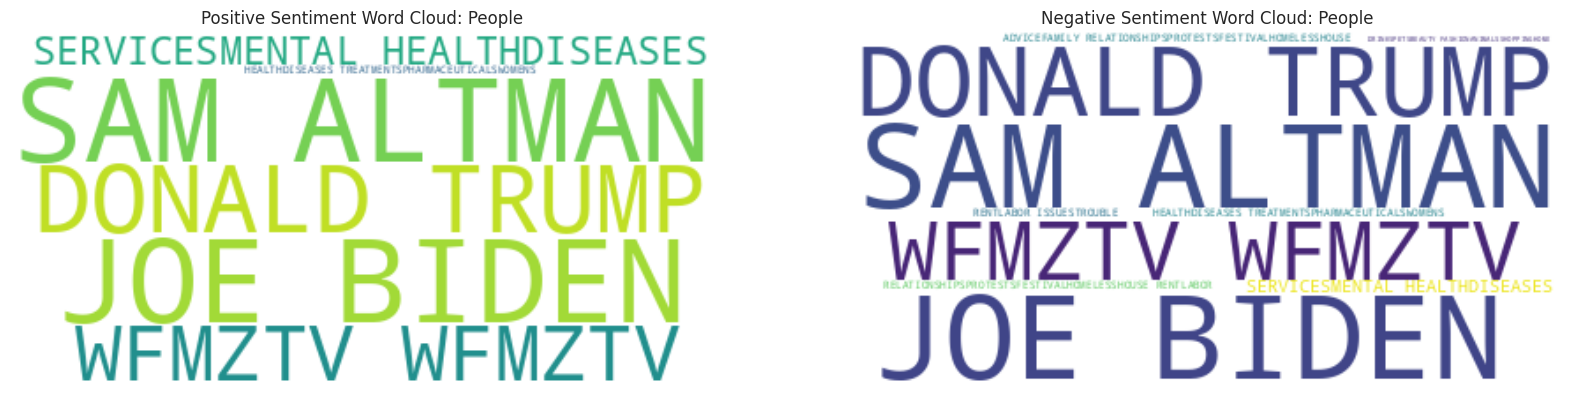

In [ ]:
# Plot the word clouds
plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
plt.imshow(tb_positive_peo_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud: People')

plt.subplot(1, 2, 2)
plt.imshow(tb_negative_peo_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud: People')

plt.show()

#### Organization

In [ ]:
# Create separate DataFrames for each sentiment label
tb_positive_org_nested_list = sample_df.loc[sample_df['sentiment_label_trans'] == 'positive','top_org'].tolist()
tb_negative_org_nested_list = sample_df.loc[sample_df['sentiment_label_trans'] == 'negative','top_org'].tolist()

# Flatten the nested list into a single list
tb_positive_org_single_list = flatten_nested_list(tb_positive_org_nested_list)
tb_negative_org_single_list = flatten_nested_list(tb_negative_org_nested_list)

# Concatenate the text data for each sentiment label into separate strings
tb_positive_org_text = ' '.join(tb_positive_org_single_list)
tb_negative_org_text = ' '.join(tb_positive_org_single_list)

# Create WordCloud objects for each sentiment label
tb_positive_org_wordcloud = WordCloud(background_color='white').generate(tb_positive_org_text)
tb_negative_org_wordcloud = WordCloud(background_color='white').generate(tb_negative_org_text)

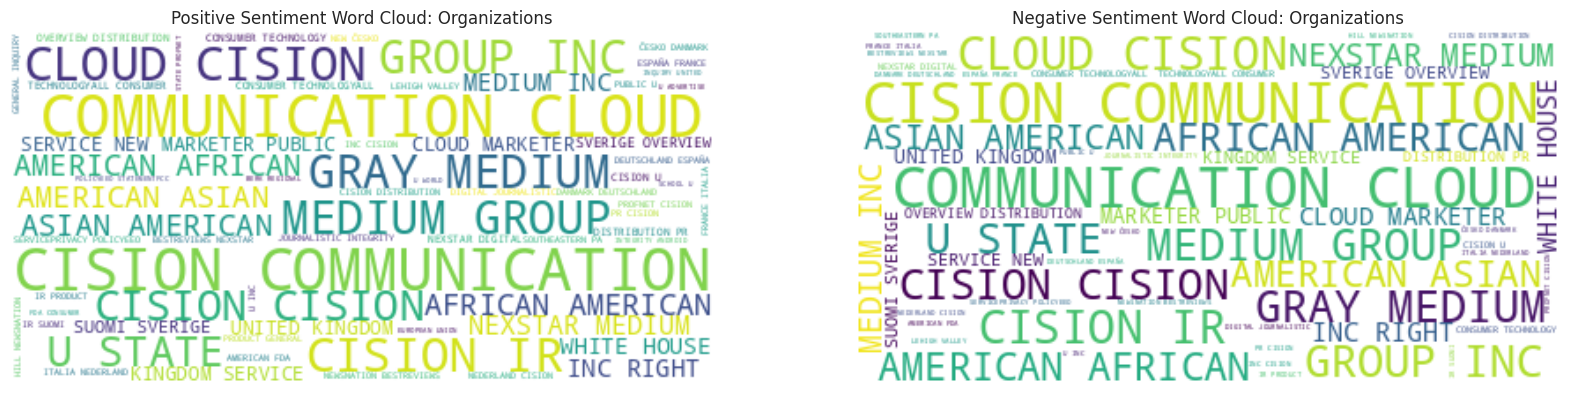

In [ ]:
# Plot the word clouds
plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
plt.imshow(tb_positive_org_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud: Organizations')

plt.subplot(1, 2, 2)
plt.imshow(tb_negative_org_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud: Organizations')

plt.show()

### Plots by sentiment and type

In [ ]:
# Explode the list column to create multiple rows
tb_peo_sentiment_df = sample_df.explode('top_peo')
tb_peo_sentiment_df = tb_peo_sentiment_df[['top_peo','sentiment_label_trans']]
tb_peo_sentiment_df = tb_peo_sentiment_df[tb_peo_sentiment_df['top_peo'] != '']
#tb_peo_sentiment_df.dropna(subset='top_peo', inplace=True, ignore_index=True)

tb_org_sentiment_df = sample_df.explode('top_org')
tb_org_sentiment_df = tb_org_sentiment_df[['top_org','sentiment_label_trans']]
tb_org_sentiment_df = tb_org_sentiment_df[tb_org_sentiment_df['top_org'] != '']
#tb_org_sentiment_df.dropna(subset='top_org', inplace=True, ignore_index=True)

# Group the data by target entity
tb_peo_sentiment_counts = tb_peo_sentiment_df.groupby(['top_peo','sentiment_label_trans']).size().reset_index(name='count')
tb_peo_sentiment_pivot = tb_peo_sentiment_counts.pivot_table(
    values='count', index='top_peo', columns='sentiment_label_trans', aggfunc='sum', margins=True, margins_name='Total')
tb_peo_sentiment_pivot = tb_peo_sentiment_pivot.drop('Total', axis=0).reset_index()
tb_peo_sentiment_pivot.sort_values(by=['Total', 'top_peo'], ascending=[False, True], inplace=True, ignore_index=True)

tb_org_sentiment_counts = tb_org_sentiment_df.groupby(['top_org','sentiment_label_trans']).size().reset_index(name='count')
tb_org_sentiment_pivot = tb_org_sentiment_counts.pivot_table(
    values='count', index='top_org', columns='sentiment_label_trans', aggfunc='sum', margins=True, margins_name='Total')
tb_org_sentiment_pivot = tb_org_sentiment_pivot.drop('Total', axis=0).reset_index()
tb_org_sentiment_pivot.sort_values(by=['Total', 'top_org'], ascending=[False, True], inplace=True, ignore_index=True)

In [ ]:
tb_peo_sentiment_pivot = tb_peo_sentiment_pivot.head()
tb_peo_sentiment_pivot

sentiment_label_trans,top_peo,0,negative,positive,Total
0,SAM ALTMAN,27.0,175.0,1937.0,2139
1,BIDEN,22.0,150.0,1694.0,1866
2,JOE BIDEN,12.0,115.0,1445.0,1572
3,DONALD TRUMP,12.0,119.0,1281.0,1412
4,KUTZTOWN,NaN,119.0,863.0,982


In [ ]:
tb_org_sentiment_pivot = tb_org_sentiment_pivot.head()
tb_org_sentiment_pivot

sentiment_label_trans,top_org,0,negative,positive,Total
0,CHATGPT,232.0,1896.0,11445.0,13573
1,IBM,37.0,2686.0,6047.0,8770
2,MICROSOFT,92.0,1709.0,6437.0,8238
3,ANDROID,45.0,713.0,5397.0,6155
4,GOOGLE,90.0,762.0,4646.0,5498


<ipython-input-258-ffbaa72f805d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)
<ipython-input-258-ffbaa72f805d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)


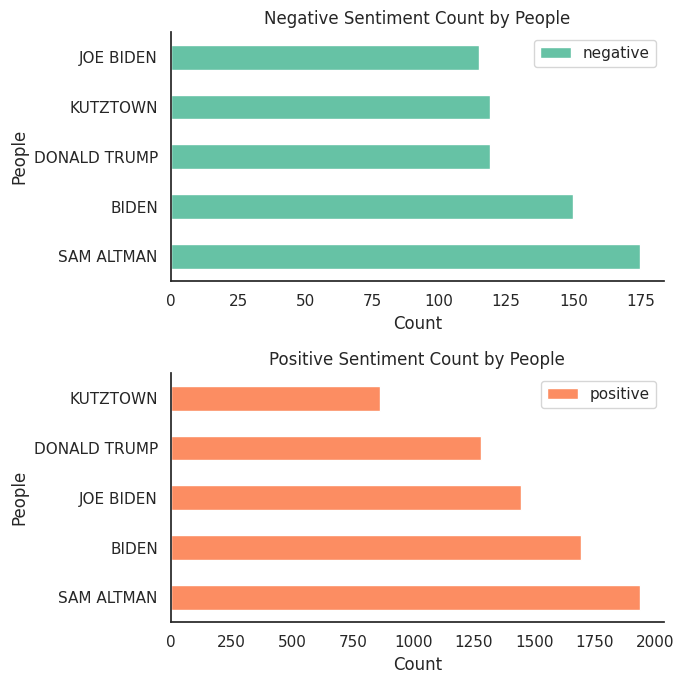

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

for i, col in enumerate(['negative', 'positive']):
    sub_plot = tb_peo_sentiment_pivot[['top_peo', col]]
    sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)

    ax = axes[i]
    sub_plot.head(10).plot(x='top_peo', y=col, kind='barh', ax=ax, color=sns.color_palette("Set2")[i])
    ax.set_title(f'{col.capitalize()} Sentiment Count by People')
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_xlabel('Count')
    ax.set_ylabel('People')

plt.tight_layout()
sns.despine()

plt.show()

<ipython-input-259-b92b3994b73e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)
<ipython-input-259-b92b3994b73e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)


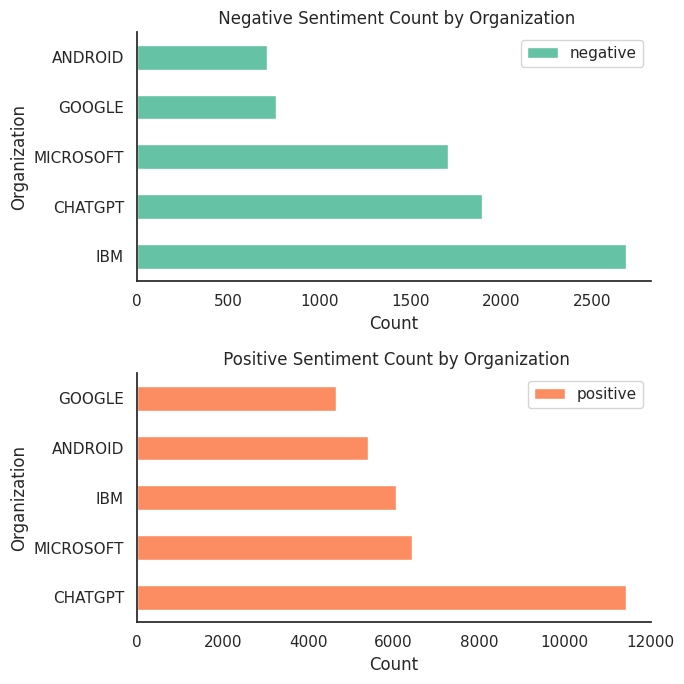

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

for i, col in enumerate(['negative', 'positive']):
    sub_plot = tb_org_sentiment_pivot[['top_org', col]]
    sub_plot.sort_values(by=col, ascending=False, inplace=True, ignore_index=True)

    ax = axes[i]
    sub_plot.head(10).plot(x='top_org', y=col, kind='barh', ax=ax, color=sns.color_palette("Set2")[i])
    ax.set_title(f' {col.capitalize()} Sentiment Count by Organization')
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_xlabel('Count')
    ax.set_ylabel('Organization')

plt.tight_layout()
sns.despine()

plt.show()